In [1]:
from keras.layers import Input,Dense
from keras.models import Model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import keras

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
%%time
import os
for dirPath, dirNames, fileNames in os.walk("figure"):
    pass
data=[]
for name in fileNames:
    path='figure/'+name
    img=mpimg.imread(path)
    #data.append(img[6:34,6:34,0:4])
    data.append(img[4:36,4:36,0:4])
data=np.array(data)

x_train=data[:-3]
x_test=data[-3:]

x_train=x_train.reshape(len(x_train),32,32,4)
x_test=x_test.reshape(len(x_test),32,32,4)

print('x_train shape=',x_train.shape)
print('x_test shape=',x_test.shape)

x_train shape= (789, 32, 32, 4)
x_test shape= (3, 32, 32, 4)
CPU times: user 229 ms, sys: 95.5 ms, total: 324 ms
Wall time: 524 ms


In [17]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Reshape, Layer, Lambda, Flatten
from keras.models import Model
from keras import backend as K

input_img=Input(shape=(32,32,4))

conv1=Conv2D(32,(2,2),activation='relu',padding='same')(input_img)
#maxpool1=MaxPooling2D((2,2),padding='same')(conv1)
conv2=Conv2D(32,(2,2),activation='relu',padding='same')(conv1)
#maxpool2=MaxPooling2D((2,2),padding='same')(conv2)
conv3=Conv2D(32,(2,2),activation='relu',padding='same')(conv2)
maxpool3=MaxPooling2D((2,2),padding='same')(conv3)
flat=Flatten()(maxpool3)
dense1=Dense(32*32)(flat)
dense2=Dense(128)(dense1)
dense3=Dense(32)(dense2)
z_mean=Dense(10)(dense3)
z_log_var=Dense(10)(dense3)
def sampling(args):
    z_mean, z_log_var = args
    #epsilon是常態分布下亂數取出的noise
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], 1), mean=0.,
                              stddev=1)
    return z_mean + K.exp(z_log_var / 2) * epsilon
z = Lambda(sampling)([z_mean, z_log_var])
encoder=Model(input_img,z)

decoder_input=Input(shape=(10,))
dec_dense1=Dense(32)
dec_dense2=Dense(128)
dec_reshape=Reshape((4,4,8))
dec_conv1=Conv2D(32,(3,3),activation='relu',padding='same')
dec_ups1=UpSampling2D((2,2))
dec_conv2=Conv2D(32,(3,3),activation='relu',padding='same')
dec_ups2=UpSampling2D((2,2))
dec_conv3=Conv2D(32,(3,3),activation='relu',padding='same')
dec_ups3=UpSampling2D((2,2))
dec_conv4=Conv2D(4,(3,3),activation='sigmoid',padding='same')

x=dec_dense1(z)
x=dec_dense2(x)
x=dec_reshape(x)
x=dec_conv1(x)
x=dec_ups1(x)
x=dec_conv2(x)
x=dec_ups2(x)
x=dec_conv3(x)
x=dec_ups3(x)
x=dec_conv4(x)

decoder=dec_dense1(decoder_input)
decoder=dec_dense2(decoder)
decoder=dec_reshape(decoder)
decoder=dec_conv1(decoder)
decoder=dec_ups1(decoder)
decoder=dec_conv2(decoder)
decoder=dec_ups2(decoder)
decoder=dec_conv3(decoder)
decoder=dec_ups3(decoder)
decoder=dec_conv4(decoder)

decoder=Model(decoder_input,decoder)

In [ ]:
from keras import metrics
class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        # 呼叫Layer的建構子__init__
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, input_img, x):
        input_img=Flatten()(input_img)
        x=Flatten()(x)
        xent_loss = 4096 * (metrics.binary_crossentropy((input_img), (x)))
        kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var),axis=1)
        return K.sum(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        x_decoded_mean = inputs[1]
        loss = self.vae_loss(x, x_decoded_mean)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return x

y = CustomVariationalLayer()([input_img, x])
vae = Model(input_img, y)
vae.compile(optimizer='adam', loss=None)
vae.summary()
vae.fit(x=x_train,shuffle=True,epochs=100,validation_data=(x_test,None),batch_size=32)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Output "custom_variational_layer_6" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_6" during training.


Train on 789 samples, validate on 3 samples
Epoch 1/100
789/789 [==============================] - 8s 10ms/step - loss: 66462.6625 - val_loss: 9062.5381
Epoch 2/100
789/789 [==============================] - 6s 8ms/step - loss: 45509.9738 - val_loss: 8755.0938
Epoch 3/100
789/789 [==============================] - 6s 8ms/step - loss: 42183.0021 - val_loss: 8574.5098
Epoch 4/100
789/789 [==============================] - 6s 8ms/step - loss: 40299.4433 - val_loss: 8544.4443
Epoch 5/100
789/789 [==============================] - 6s 8ms/step - loss: 38649.7986 - val_loss: 8385.5264
Epoch 6/100
789/789 [==============================] - 6s 8ms/step - loss: 37621.5871 - val_loss: 8348.3037
Epoch 7/100
789/789 [==============================] - 6s 8ms/step - loss: 36774.3713 - val_loss: 8265.3975
Epoch 8/100
789/789 [==============================] - 6s 8ms/step - loss: 36204.1624 - val_loss: 8220.0264
Epoch 9/100
789/789 [==============================] - 6s 8ms/step - loss: 35781.5968 - val

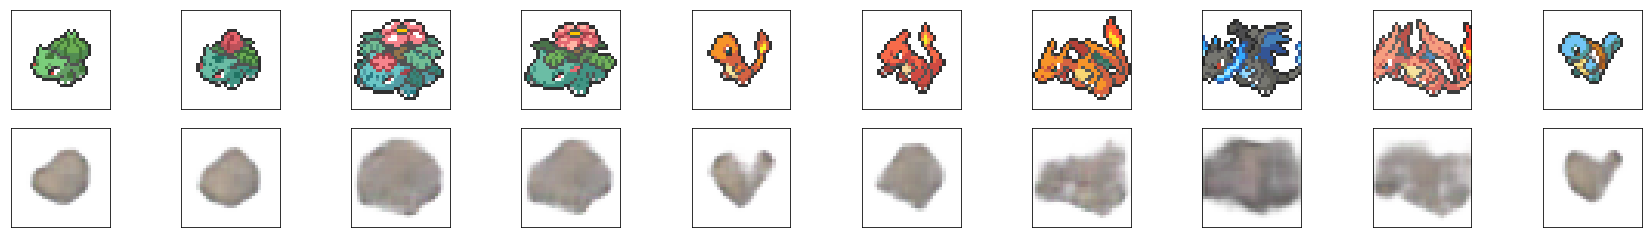

In [15]:
encoded_imgs = encoder.predict(x_train)
decoded_imgs = decoder.predict(encoded_imgs)
n = 10  # how many digits we will display
plt.figure(figsize=(30, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    imgplot = plt.imshow(x_train[i])
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    imgplot = plt.imshow(decoded_imgs[i])
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [125]:
import json
from keras.applications import imagenet_utils
with open('./vae.json', 'w') as jsOut:
    json.dump(vae.to_json(), jsOut)
vae.save_weights('./vae_weight.h5')

In [168]:
from keras.models import model_from_json
import json
with open('./vae.json', 'r') as jsIn:
    vae=json.load(jsIn)